# 당뇨 환자의 재입원 요인 분석

[인공지능, 심질환자 재입원 가능성 예측](http://khiss.go.kr/board/view?pageNum=1&rowCnt=10&menuId=MENU00307&schType=0&schText=&categoryId=&continent=&country=&boardStyle=&linkId=63698) 기사를 보고 저도 한번 비슷한 문제를 풀어보고 싶었습니다.  인터넷에 공개되어있는 데이터 중에 [당뇨환자의 재입원 데이터](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008)가 있더군요. 또한 당뇨환자들은 재입원 비율이 일반환자보다 높다고 알려져있습니다 [관련 논문](https://clindiabetesendo.biomedcentral.com/articles/10.1186/s40842-016-0040-x). 그래서 제가 한번 해봤습니다.

## 재입원이 왜 문제죠?

![image](https://www.openplacement.com/uploads/op/files/revolvingdoor-11.07_.12_.jpg)

환자의 재입원이 문제라고 합니다.  최근 퇴원한 지 30일 이내에 재입원하는 환자의 전체의 20%에 이른다고 합니다(2014년도 미국기준). 이러한 잦은 입원으로 인한 비용의 증가는 의료보험의 재정을 위협하고 있습니다. 

> 미국 보건당국은 병원재입원감소대책을 수립하고 재입원에 대해 벌칙도 정했다. [관련뉴스기사](http://www.docdocdoc.co.kr/news/articleView.html?idxno=151962)

이들은 중환자와는 달리 입원해서 치료를 받으면 안정을 되찾고 회복 상태로 지내지만 퇴원을 하게 되면 즉각적인 대응과 치료가 여의치 않아 상태가 나빠지는 환자들입니다.  대체로 고령이고, 이미 만성질환을 가지고 있어 급성 스트레스나 상해에 취약합니다. 이런 환자를 처음 입원 때부터 확인하고 관리한다면 비용절감과 환자의 삶이 개선될 수 있을 것입니다.  

## 분석에 사용한 데이터

사용한 데이터셋은 인터넷에 공개되어 있는 것을 사용했고 구체적인 정보는 다음과 같습니다.
- [데이터 다운로드](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)
- Rubin, Daniel J (2015). "Hospital readmission of patients with diabetes". Current Diabetes Reports. 15 (4): 1–9. doi:10.1007/s11892-015-0584-7.  
> 저는 Kaggle에서 작업하였습니다.   

1999년부터 2008년까지 근 10년간 미국 각지의 130개의 병원에서 수집된 데이터입니다. 50개가 넘는 항목을 포함하고 있으며 다음의 기준을 따르고 있습니다.  

1. 입원한 환자만의 결과입니다.
2. 당뇨병으로 진단된 환자입니다.
3. 하루이상의 입원이며, 대체로 14일을 입원하였습니다.
4. 일반 검사(Laboratory tests)는 입원중에 시행되었습니다.
5. 의약품은 모두 입원중에 처방되었습니다.

# 데이터 불러오기
분석을 시작하기 앞서 사용할 파이썬 라이브러리와 데이터를 불러오겠습니다.

In [22]:
# 분석에 필요한 라이브러리 불러오기
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./input/diabetic_data.csv', na_values='?', low_memory=False) 
# 결측치는 ?로 표시되어 있습니다.
df.tail() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),NaN,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


데이터는 50개의 행(columns)으로 구성되어 있습니다. 총 데이터의 갯수가 10000개로 알려져 있었는데 더 늘어난 101765인것을 확인 할 수 있습니다. 각각의 열의 데이터가 어떤 의미인지는 아래에서 설명하도록 하겠습니다.

# 데이터셋 설명
분석하기 앞서 데이터셋의 정보를 알아보겠습니다. 

## Feature 이름과 설명
데이터셋을 이루고 있는 **Feature**들을 다음의 표로 정리하였습니다.

Feature name | 데이터 형태(Type)| 설명
---|---|---
Encounter ID |	수치형 | 입원의 고유한 식별값
Patient number | 수치형 | 환자의 고유한 식별값
Race |	명목형	| 인종: Caucasian, Asian, African American, Hispanic, other
Gender	| 명목형 | 성별: 남성(male), 여성(female), 알수없음(unknown)
 Age | 명목형 | 10년 단위로 묶여 있음: [0-10], [10-20] … [90-100]
 Weight |	수치형	| 몸무게 (파운드 단위)
Admission type |	명목형	| 입원 형태의 9가지의 숫자 식별값, emergency, urgent, elective, newborn 등등
Discharge disposition | 명목형 | 퇴원 처리의 29가지의 숫자 식별값,  집으로 퇴원, expired 등등
Admission source | 명목형	| 입원 원인의 21가지 숫자 식별값, 의사 추천, 응급실, 다른 병원에서 옮김
Time in hospital | 수치형 | 입원 기간(일)
Payer code | 명목형 | 의료 보험의 23가지의 숫자 식별값, Blue Cross, Medicare, 직접 지불 등등
Medical specialty	| 명목형 | 입원 시킨 의사의 전공 84가지의 숫자 식별값, 심장, 내과, 가정 / 일반 진료 및 외과 의사
Number of lab procedures | 수치형 | 입원동안 수행한 일반 검사(Lab tests) 횟수
Number of procedures | 수치형 | 입원동안 수행한 특수 검사 횟수
Number of medications	 | 수치형 | 입원동안 투약한 의약품의 수 
Number of outpatient visits	 | 수치형	| 외래방문건수, 입원전의 통원 치료 방문 횟수 (1년간) 
Number of emergency visits | 수치형 | 응급실방문건수, 입원전의 응급실 방문 횟수 (1년간)
Number of inpatient visits | 수치형 | 입원횟수, 입원전의 입원 횟수 (1년간)
Diagnosis 1	| 명목형 | 1차 진단(ICD9의 처음 세 자리 숫자), 848 개의 고유 값
Diagnosis 2 | 명목형 | 2차 진단(ICD9의 처음 세 자리 숫자), 923 개의 고유 값
Diagnosis 3 | 명목형 | 추가 2차 진단 (ICD9의 처음 세 자리 숫자), 954 개의 고유 값
Number of diagnoses	| 수치형 | 진단 횟수
Glucose serum test result |	명목형 | 포도당 혈청 검사 결과
A1c test result |	명목형	 | A1c 시험 결과 값, 8% 이상이면  **>8** 7% 이상이면 **>7** 7% 이하면 **Normal** 표기
Change of medications |	명목형 | 당뇨병 치료제(복용량 또는 약품)가 변경 여부 
Diabetes medications | 명목형 | 당뇨병 치료제가 처방되었는지 여부, **yes** 혹은 **no**
24 features for medications | 명목형 | 24가지의 약물이 처방되었는지 또는 복용량의 변화 여부를 나타냅니다, 입원중 복용량이 증가하면 **up** 줄어들면 ** down**  변화가 없으면 **steady** 처방되지 않으면 **no**로 표기 
Readmitted | 명목형 | 퇴원 30일 이내 재입원은 **> 30** 30일 이후 재입원은 **< 30** 재입원 데이터가 없는 경우 ** No**로 표기 

# 미리 알아야 할 것!
데이터를 분석하기 앞서 미리 알아야할 것들을 공부해보도록 하겠습니다.

## 당뇨병
아주 흔한 대사질환으로 혈당 조절에 장애가 발생하는 것입니다. 인슐린에 의해 Type1, Type2 로 구분하는게 일반적이고 완치는 어렵다는게 중론입니다.

## 당화혈색소(HbA1c) 검사
참고: https://labtestsonline.kr/tests/hba1c

> 당화혈색소(glycated hemoglobin, HbA1c)란 장기간 동안 혈중 포도당(혈당) 농도를 알기 위해 사용하는 혈색소의 한 형태이다.  -wikipedia

우리 몸의 혈액에는 120일 정도의 수명을 적혈구가 존재하며, 적혈구 안에 있는 혈색소가 포도당과 결합하면서 당화혈색소를 형성합니다. 당뇨환자는 혈당이 잘 조절되지 않아 당화혈색소의 수치가 증가하게 된됩니다.  당화혈색소의 정상수치는 4 ~ 5.9% 입니다. 당뇨환자의 당화혈색소 조절 목표를 6.5%이하로 보고 있습니다. 

# 탐색적 데이터 분석 (EDA) 부터
제일 간단하게 할 수 있는 `pandas.DataFrame.describe()`기능을 사용해 보겠습니다. (이 기능은 수치형 데이터에만 적용됩니다.)

In [23]:
df.describe().transpose() # Transpose를 통해 좀더 보기 쉽게 합니다

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


살펴보니 그다지 정보는 없는 것 같습니다.  총 환자수는 **patient_nbr**의 갯수인 101766명입니다.  그리고 **time_in_hospital, num_lab_procedures, num_medications,  number_diagnoses** 의 최대 최소값 정도를 알 수 있는데, 시각화를 통해 정규분포 형태인지 확인해 보겠습니다. 

## 원시 데이터 시각화

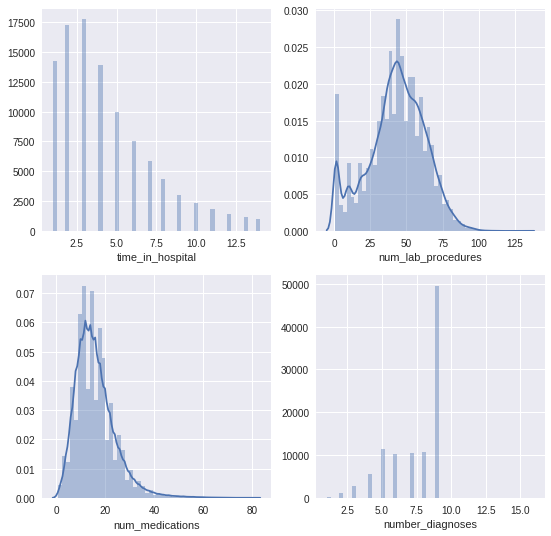

In [24]:
f, ([ax0, ax1], [ax2, ax3]) = plt.subplots(nrows=2,ncols=2, sharey=False, figsize=(9, 9))
f= sns.distplot(df.time_in_hospital, kde=False, ax = ax0)
f = sns.distplot(df.num_lab_procedures, kde=True, ax = ax1)
f = sns.distplot(df.num_medications, kde=True, ax = ax2)
f= sns.distplot(df.number_diagnoses, kde=False, ax = ax3)

위의 그림으로 부터 알 수 있는 것은 다음과 같습니다.

- time_in_hospital을 보면 보통 2~3일 정도 입원한다는 것을 알 수 있습니다.
- 입원중 일반 검사를 50개정도 합니다만,  아예 안하는 경우도 적지 않습니다.
- 평균적으로 약 18개를 투약합니다.
- 대부분의 진단은 9번 내립니다. 그리고 정규분포의 형태는 아니군요.

진단횟수에 따라서 그룹을 만들수 있지 않을까?하는 생각이 듭니다.

## 인종이나 성별의 차이가 존재 할까?

간단하게 재입원율에 인종이나 성별의 차이가 있는지 알고 싶습니다. 그림으로 한눈에 보고 싶은데, 기존의 데이터 형식으로는 어려워 보입니다. 간단한 피봇 테이블을 만들어 보겠습니다.

In [25]:
# 피봇 테이블 만들기
df_race = pd.pivot_table(df, index=['race','gender'], columns=['readmitted'] ,values=['encounter_id'],
                         aggfunc=lambda x: len(x.unique()),margins=True)
# 재입원 비율을 계산해 행을 추가합니다.
df_race['encounter_id','readmit_ratio'] = 1- df_race['encounter_id','NO'] / df_race['encounter_id','All'] 
df_race

encounter_id                             \
readmitted                               <30      >30       NO      All   
race            gender                                                    
AfricanAmerican Female                1300.0   4102.0   6326.0  11728.0   
                Male                   855.0   2532.0   4095.0   7482.0   
Asian           Female                  24.0     89.0    205.0    318.0   
                Male                    41.0     72.0    210.0    323.0   
Caucasian       Female                4560.0  14488.0  20641.0  39689.0   
                Male                  4032.0  12636.0  19742.0  36410.0   
Hispanic        Female                 100.0    354.0    638.0   1092.0   
                Male                   112.0    288.0    545.0    945.0   
Other           Female                  77.0    224.0    447.0    748.0   
                Male                    68.0    222.0    467.0    757.0   
                Unknown/Invalid          NaN      NaN      1.0      1.0   
All                                  11169.0  35007.0  53317.0  99493.0   

                                               
readmitted                      readmit_ratio  
race            gender                         
AfricanAmerican Female               0.460607  
                Male                 0.452686  
Asian           Female               0.355346  
                Male                 0.349845  
Caucasian       Female               0.479931  
                Male                 0.457786  
Hispanic        Female               0.415751  
                Male                 0.423280  
Other           Female               0.402406  
                Male                 0.383091  
                Unknown/Invalid      0.000000  
All                                  0.464113

인종, 성별간의 데이터를 살펴보니,  성별간의 차이는 거의 미비해 보입니다. 오히려 인종간에는 차이가 있어보이는군요. 그림으로 그려볼게요.

## 인종별  재입원율 시각화

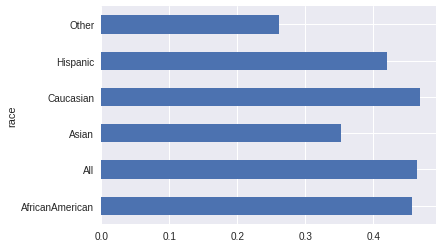

In [26]:
# f = df_race['encounter_id','readmit_ratio'].groupby('race').mean().plot(kind='barh')
g = df_race['encounter_id','readmit_ratio'].reset_index()
g = g.groupby('race').mean().plot(kind='barh', legend=False)

**Other** 그룹이 값이 낮아 보이지만, 실은 **Unknown/Invalid**의 재입원율이 ** 0**이기 때문에 평균값이 낮아졌기 때문입니다. 결론적으로 **Asian**의 평균 재입원율만 전체에 재입원율에 대비 낮다고 볼 수 있겠습니다.

## 데이터셋에 누락된 값이 있는가?

In [27]:
df_null = df.isnull().apply(sum)
df_null[df_null > 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

몸무게는 전체의 97%가 누락되어 있네요. 이렇게 많이 누락된 **몸무게 값은 삭제해도 괜찮을 것 같습니다.**
**payer_code, medical_specialty** 또한 절반이상이 누락되어 있습니다.  그리고 환자의 상태와는 관련이 없어 보이기 때문에 저는 **데이터를 빼고** 진행 하겠습니다.

# 데이터셋 정제하기

탐색적 데이터 분석(EDA)를 해보니, 추가적 분석을 위해 원시 데이터(raw data)을 정제해야 할 것 같습니다.  그래서 아래와 같은 사항을 변경했습니다.
1. 범위로 표현된 나이(명목형)를 나이의 중간 값(숫자형)으로 수정
2. **max_glu_serum, A1Cresult, change ** 등의 명목형 값은 직접 숫자형 데이터로 변환
3. 범주형 값인 **인종, 성별** 등의 값은 `Categorical.codes` 기능을 사용해 변환
4. 불필요해 보이는 **몸무게, 보험사 번호, 담당의 전공** 등의 열은 삭제


In [28]:
# df[['diag_1','diag_2','diag_3']].replace(regex={r'^[VE][0-9]+$':100}, inplace = False) # other diag for 100
df['diag_1'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)
df['diag_2'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)
df['diag_3'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)

In [29]:
df['diag_1'] = df['diag_1'].astype(np.float64)
df['diag_2'] = df['diag_2'].astype(np.float64)
df['diag_3'] = df['diag_3'].astype(np.float64)

In [30]:
diag = ['diag_1','diag_2','diag_3']
for i in diag:
    conditions = [
        (df[i] <= 100 ),
        (df[i] >= 140 ) & (df[i] < 240),
        (df[i] >= 250 ) & (df[i] < 251),
        (df[i] >= 390 ) & (df[i] < 460),
        (df[i] >= 460 ) & (df[i] < 520),
        (df[i] >= 520 ) & (df[i] < 580),
        (df[i] >= 580 ) & (df[i] < 630),
        (df[i] >= 710 ) & (df[i] < 740),
        (df[i] >= 800 ) & (df[i] < 1000),        
        (df[i] == 785),
        (df[i] == 786),
        (df[i] == 787),
        (df[i] == 788)]
    choices = ['other','neoplasms','diabetes','circulatory','respiratory','digestive',
               'genitourinanry','musculoskeletal','injury','circulatory','respiratory','digestive','genitourinanry']
    df[i] = np.select(conditions, choices)

In [31]:
df[['diag_1','diag_2','diag_3']]

,diag_1,diag_2,diag_3
0,diabetes,0,0
1,0,diabetes,0
2,0,diabetes,other
3,other,diabetes,circulatory
4,neoplasms,neoplasms,diabetes
5,circulatory,circulatory,diabetes
6,circulatory,circulatory,other
7,circulatory,respiratory,diabetes
8,circulatory,circulatory,other
9,circulatory,neoplasms,respiratory


In [32]:
df['age'].replace({ '[0-10)':5, '[10-20)':15, 
                     '[20-30)':25, '[30-40)':35, 
                     '[40-50)':45, '[50-60)':55, 
                     '[60-70)':65, '[70-80)':75,
                     '[80-90)':85, '[90-100)':95}, inplace = True)

df['max_glu_serum'].replace({'None':0,'Norm':100,
                             '>200': 200, '>300':300}, inplace = True)

df['A1Cresult'].replace({'None':0, 'Norm':10,
                        '>7':20, '>8':30}, inplace = True)

df['change'].replace({'No':0, 'Ch':1}, inplace = True)

df['diabetesMed'].replace({'No':0, 'Yes':1}, inplace = True)

medications = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
               "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
               "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", 
               "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
               "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]
for i in medications:
    df[i].replace({'No': -1,'Down': 0,'Steady': 1,'Up': 2}, inplace = True)



categoricals = ['race','gender', 'payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3']
for j in categoricals:
    df[j] = pd.Categorical(df[j]).codes #  integer 값으로 바꿔 줍니다.
    df[j].astype('int64')
    
df['readmitted'].replace({'NO':0, '>30':1, '<30':1}, inplace = True)
# 쓸모 없어 보이는 데이터 삭제
del_columns = ['weight'] # 삭제할 데이터
df.drop(del_columns, inplace=True, axis=1)
# Non-Important Drugs 
del_columns = ['chlorpropamide','acetohexamide', 'troglitazone', 'glyburide-metformin', 'glimepiride-pioglitazone', 'metformin-pioglitazone']
df.drop(del_columns, inplace=True, axis=1)

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,miglitol,tolazamide,examide,citoglipton,insulin,glipizide-metformin,metformin-rosiglitazone,change,diabetesMed,readmitted
0,2278392,8222157,2,0,5,6,25,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,0,0,0
1,149190,55629189,2,0,15,1,1,7,3,-1,...,-1,-1,-1,-1,2,-1,-1,1,1,1
2,64410,86047875,0,0,25,1,1,7,2,-1,...,-1,-1,-1,-1,-1,-1,-1,0,1,0
3,500364,82442376,2,1,35,1,1,7,2,-1,...,-1,-1,-1,-1,2,-1,-1,1,1,0
4,16680,42519267,2,1,45,1,1,7,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,1,0


정제한 데이터는 47개의 행을 가지고 있습니다. **encounter_id ,patient_nbr **는 환자 고유값이기 때문에 학습 직전에 빼줄 예정입니다.

## 나이별 데이터의 수
나이별 환자의 수는 다음과 같습니다.

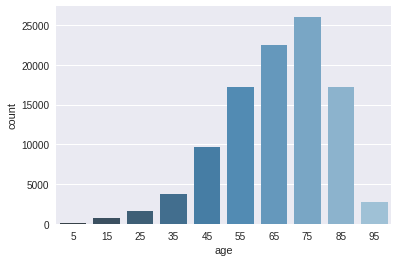

In [33]:
# 나이
f = sns.countplot(df.age, palette='Blues_d')

나이별 환자의 재입원과 퇴원을 비교해 시각화 해보면 다음과 같습니다.

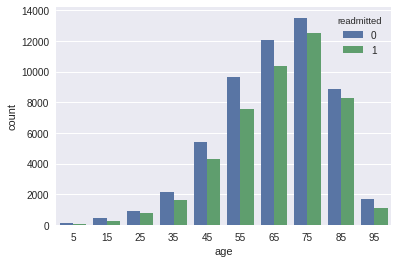

In [34]:
f = sns.countplot(x="age", hue="readmitted", data=df)

나이가 45~65살 사이에는 재입원율이 낮아 보이는데, 좀 더 명확하게 보기 위해 다시 피벗 테이블을 만들고 시각화로 확인해 보겠습니다.

## 나이별 재입원율 피벗테이블

In [35]:
df_age =pd.pivot_table(df, index=['age'], columns=['readmitted'] ,values=['encounter_id'],
                       aggfunc=lambda x: len(x.unique()),margins=True)
df_age['encounter_id','readmitted_ratio'] = 1- (df_age['encounter_id',0] / df_age['encounter_id','All'] )
df_age

encounter_id                                    
readmitted            0        1       All readmitted_ratio
age                                                        
5                 132.0     29.0     161.0         0.180124
15                427.0    264.0     691.0         0.382055
25                911.0    746.0    1657.0         0.450211
35               2164.0   1611.0    3775.0         0.426755
45               5380.0   4305.0    9685.0         0.444502
55               9671.0   7585.0   17256.0         0.439557
65              12084.0  10399.0   22483.0         0.462527
75              13524.0  12544.0   26068.0         0.481203
85               8896.0   8301.0   17197.0         0.482700
95               1675.0   1118.0    2793.0         0.400286
All             54864.0  46902.0  101766.0         0.460881

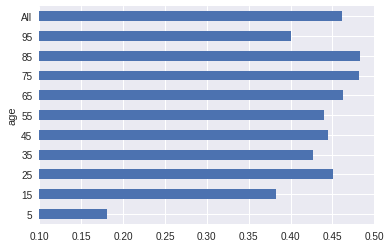

In [36]:
f = df_age['encounter_id','readmitted_ratio'].plot(kind='barh', xlim=(0.1,0.5))

확실하게 나이대 별로 재입원하는 비율이 다릅니다.  
- 15세 이하의 나이는 재입원 비율이 낮아 보입니다. 특히 5세는 아주 낮네요.
- 재입원하는 비율은 25세이상에서 85세까지는 45%정도를 유지합니다.
- 95세에 가서는 다시 줄어드는 모습을 보이는데, 아마도 사망과 관련있지 않을까 생각합니다.
- 전체 평균 재입원 비율을 46%입니다.


<아래 내용은 일단 정지>
## 환자의 나이대에 따라 그룹화 하기
`numpy.select()`기능을 사용해 다양한 조건으로 그룹화가 가능합니다.

In [37]:
conditions = [
    (df['age'] <= 5 ),
    (df['age'] >= 15 ) & (df['age'] < 25),
    (df['age'] >= 25 ) & (df['age'] < 65),
    (df['age'] >= 65 ) & (df['age'] < 95),
    (df['age'] >= 95)]
choices = [0, 1, 2, 3, 4]
df['age'] = np.select(conditions, choices)

## 진단 횟수의 따라 재입원율 차이
피벗테이블을 만들어 차이가 있는지 확인해보겠습니다.

In [38]:
df_diag =pd.pivot_table(df, index=['number_diagnoses'], columns=['readmitted'] ,values=['encounter_id'],
                       aggfunc=lambda x: len(x.unique()),margins=True)
df_diag['encounter_id','readmitted_ratio'] = df_diag['encounter_id',1] / df_diag['encounter_id','All'] 
df_diag

encounter_id                                    
readmitted                  0        1       All readmitted_ratio
number_diagnoses                                                 
1                       167.0     52.0     219.0         0.237443
2                       687.0    336.0    1023.0         0.328446
3                      1863.0    972.0    2835.0         0.342857
4                      3474.0   2063.0    5537.0         0.372584
5                      7354.0   4039.0   11393.0         0.354516
6                      5706.0   4455.0   10161.0         0.438441
7                      5542.0   4851.0   10393.0         0.466756
8                      5564.0   5052.0   10616.0         0.475885
9                     24448.0  25026.0   49474.0         0.505841
10                        9.0      8.0      17.0         0.470588
11                        3.0      8.0      11.0         0.727273
12                        5.0      4.0       9.0         0.444444
13                        7.0      9.0      16.0         0.562500
14                        3.0      4.0       7.0         0.571429
15                        5.0      5.0      10.0         0.500000
16                       27.0     18.0      45.0         0.400000
All                   54864.0  46902.0  101766.0         0.460881

평균 재입원율은 46%인데 6번 이하로 진단받은 환자는 재입원율이 낮습니다. 반면에 7회이상은 평균 이상의 재입원율을 보입니다. 다만 12, 16번 진단 받은 환자들은 평균보다 낮기는 하지만 환자수가 너무 적어 유의미한 수치라고는 볼 수 없겠습니다. 

## 진단 횟수별로 그룹 나누기
위의 결과를 토대로 진단 횟수별로 4개의 그룹으로 만들어 보겠습니다. 나이별 그룹을 만들었던 방법을 그대로 사용하겠습니다.

In [39]:
conditions = [(df['number_diagnoses'] <= 1 ),
    (df['number_diagnoses'] >= 2 ) & (df['number_diagnoses'] < 6),
    (df['number_diagnoses'] >= 6 ) & (df['number_diagnoses'] < 9),
    (df['number_diagnoses'] >= 9 )]
choices = [0, 1, 2, 3]
df['number_diagnoses'] = np.select(conditions, choices)

## 진단 코드 정리하기
질병별로 그룹화 하기

In [40]:
df_diag =pd.pivot_table(df, index=['diag_1'], columns=['readmitted'] ,values=['encounter_id'],
                       aggfunc=lambda x: len(x.unique()),margins=True)
df_diag['encounter_id','readmitted_ratio'] = 1- (df_diag['encounter_id',0] / df_diag['encounter_id','All'] )
df_diag

encounter_id                                    
readmitted            0        1       All readmitted_ratio
diag_1                                                     
0                7566.0   6336.0   13902.0         0.455762
1               16113.0  14324.0   30437.0         0.470611
2                4302.0   4455.0    8757.0         0.508736
3                5096.0   4379.0    9475.0         0.462164
4                2846.0   2271.0    5117.0         0.443815
5                3883.0   3091.0    6974.0         0.443218
6                3015.0   1942.0    4957.0         0.391769
7                2287.0   1146.0    3433.0         0.333819
8                2268.0   2023.0    4291.0         0.471452
9                7488.0   6935.0   14423.0         0.480829
All             54864.0  46902.0  101766.0         0.460881

데이터 다듬기는 이정도로 하고 이제, 머신러닝을 시도해보도록 하겠습니다. 저는 **xgboost** 를 사용해보도록 하겠습니다. xgboost는 캐글 경연대회에서 다수의 우승자들이 사용해서 유명세를 탄 방법입니다.  xgboost에 대한 자세한 내용은 [링크](https://brunch.co.kr/@snobberys/137)를 확인하세요. 

# 머신러닝 분석 시작하기
먼저 데이터셋을 학습용과 테스트용으로 분리합니다. 그리고 데이터의 모양을 살펴보조. 

In [41]:
from sklearn.model_selection import train_test_split
y = df.readmitted # label
X = df.drop(['encounter_id', 'patient_nbr','readmitted'], axis=1) # label과 고유값을 제거
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(91589, 40) (91589,)
(10177, 40) (10177,)


`train_X`는 81412개의 열과 44개의 행으로 구성되어 있고 `train_y`는 81412개의 열과 1개의 행으로 되어 있는 것을 확인 했습니다.  `xgboost.XGBClassifier()` 라이브러리를 사용해 학습을 시작해보죠. 하이퍼 파라메터는 처음에 가장 추천되는 세팅을 검색해 사용했습니다.

In [53]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', n_jobs=-1, #  objective='binary:logistic'
                      gamma=0, min_child_weight=10,  subsample=0.8, reg_alpha=1,
                      colsample_bytree=0.8, scale_pos_weght=0.6, seed=42, base_score = 0.5)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y,eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
results = model.evals_result()
# print(results)
from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
pred_y = model.predict(test_X)
print(" AUC : {} ".format(accuracy_score(test_y, pred_y)))

 AUC : 0.6420359634469883 


In [76]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=30, learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', n_jobs=-1, #  objective='binary:logistic'
                      gamma=10, min_child_weight=100,  subsample=0.8, max_delta_step =10,
                      colsample_bytree=0.8, scale_pos_weght=0.6, seed=42)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y,eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
results = model.evals_result()
# print(results)
from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
pred_y = model.predict(test_X)
print(" accuracy_score : {} ".format(accuracy_score(test_y, pred_y)))

 accuracy_score : 0.6492090006878255 


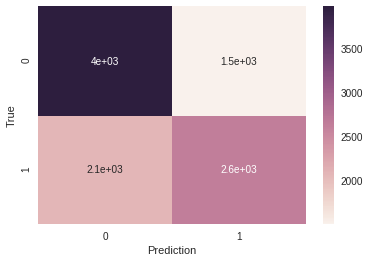

In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')
# from sklearn.metrics import f1_score
# pred_y = model.predict(test_X)
# print(" f1_score : {} ".format(f1_score(test_y, pred_y)))

XGBoost 성능이 너무 안좋아, 차라리 랜덤 포레스트를 하자


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=40, random_state=0)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')

In [ ]:
from sklearn.metrics import accuracy_score
print(" accuracy_score : {} ".format(accuracy_score(test_y, pred_y)))

In [ ]:
from sklearn.cross_validation import cross_val_score
# print(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
scores = cross_val_score(clf, X, y, cv=10)
scores

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

잘못계산해서 그렇네
 필요없는 피쳐를 빼서 해보도록 하자.

In [ ]:
del_columns = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
               "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
               "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", 
               "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
               "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone","number_emergency", "max_glu_serum","number_inpatient"] # 삭제할 데이터
df.drop(del_columns, inplace=True, axis=1)

In [ ]:
df['readmitted'].replace({0:0, 1:1, 2:1}, inplace = True)
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
y = df.readmitted # label
X = df.drop(['encounter_id', 'patient_nbr','readmitted'], axis=1) # label과 고유값을 제거
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', n_jobs=-1, #  objective='binary:logistic'
                      gamma=0, min_child_weight=1,  subsample=0.8,
                      colsample_bytree=0.8, scale_pos_weght=1, seed=1)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
results = model.evals_result()
pred_y = model.predict(test_X)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')

In [ ]:
from sklearn.cross_validation import cross_val_score
# print(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
scores = cross_val_score(model, X, y, cv=10)
scores

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=1000,
                      objective='binary:logitraw', n_jobs=-1, #  objective='binary:logistic'
                      gamma=0, min_child_weight=1,  subsample=0.8,
                      colsample_bytree=0.8, scale_pos_weght=1, seed=1)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
results = model.evals_result()
pred_y = model.predict(test_X)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')

신경망으로 갈아타야하나?


In [ ]:
df.head()

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', n_jobs=32,
                      gamma=0, min_child_weight=1,  subsample=0.8,
                      colsample_bytree=0.8, scale_pos_weight=1, seed=1)
eval_set = [(train_X, train_y), (test_X, test_y)]
model.fit(train_X, train_y, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
results = model.evals_result()
# print(results
from sklearn.metrics import mean_squared_error
pred_y = model.predict(test_X)
print(" MSE : {} ".format(mean_squared_error(test_y, pred_y)))

In [ ]:
import xgboost
n_folds = 3
early_stopping = 20
params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 42, 'silent': 1, 'nthread':-1}
xg_train = xgboost.DMatrix(X, label=y)
cv = xgboost.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1, metrics = ["error","rmse","auc"])

만든 모델이 정확한지 `accuracy_score()` 기능을 사용해 보겠습니다.

저의 예상보다 정확도가 높지는 않습니다. 이 수치를 높이기 위해 다양한 시도를 해봐야겠죠. 일단은 시각화를 통해 학습의 경과와 성능을 살펴 보겠습니다.

## 학습 시각화하기


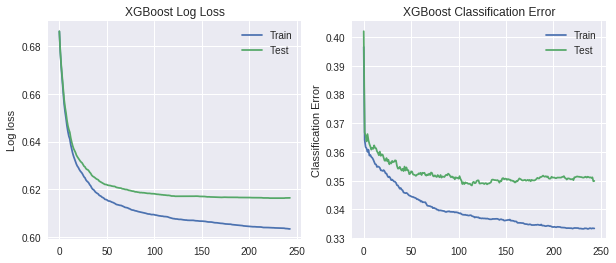

In [60]:
epochs = len(results['validation_0']['error']) # retrieve performance metrics
x_axis = range(0, epochs)
# plot log loss
f, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(10, 4))
ax0.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax0.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax0.set_title('XGBoost Log Loss')
ax0.set_ylabel('Log loss')
ax0.legend()
ax1.plot(x_axis, results['validation_0']['error'], label='Train')
ax1.plot(x_axis, results['validation_1']['error'], label='Test')
ax1.set_ylabel('Classification Error')
ax1.set_title('XGBoost Classification Error')
ax1.legend()

그림을 보니 적어도 오버피팅은 일어나지 않고 있는 모습입니다. 다만 테스트 데이터에 대한 모델의 성능이 좋지는 않아 보이는군요.

## 모델에서 features 중요도 시각화하기

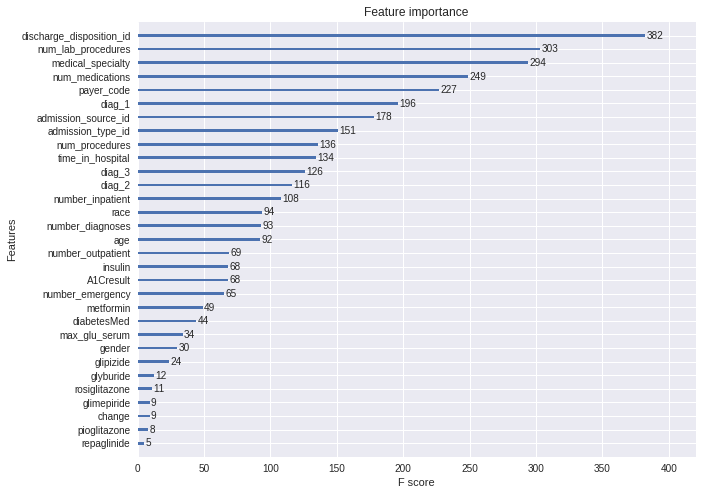

In [61]:
from xgboost import plot_importance
f, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax)

features 중요도 그림에서는 의사의 진단 재입원율에 중요하다고 나오고 있고, 그 다음으로 검사항목의 숫자와 투약한 약물의 숫자가 중요하다고 나왔습니다. 제가 예상했던 결과와 같아서 마음에 드는군요.

# 중간 결론과 앞으로 할 일

장황하게 분석을 해보았는데요, 일단은 제 모델의 성능은 마음에 들지 않네요. 성능을 올리기 위해서는 다양한 시도가 필요합니다. 다시 말해서 할 일이 너무나도 많습니다. 다시 처음으로 돌아간다면 데이터 전처리를 더 해볼 필요도 있습니다. 예를 들면 1000개가 넘는 진단코드를 질병으로 그룹을 만들면 좀 더 빠르고 정확한 결과를 얻을 수 있을 수도 있습니다.

다른 방법으로는 xgboost의 파라미터들을 최적화 시켜볼 필요도 있습니다. 다음의 [참고자료](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)를 보고 모델을 다듬어 보려고 하는데요. 

## 모델 다듬기
 왜냐하면 **xgboost**는 몇가지 변수에 의해 모델의 정확도와 속도가 극적으로 높아질수 있기 때문이죠. 모델의 파라미터를 변경하기 이전에 그것을 이해하는 것이 중요합니다.  몇가지만 테이블로 아래에 정리해보았습니다. 
 
Parameter | 설명
---|---
learning_rate | 학습률, 보통 0.01~0.2
n_estimators | 모델의 학습 반복 횟수, 너무 크면 오버피팅이 발생할 수 있습니다. 보통 100~1000
n_jobs | 사용할 CPU 코어의 수
max_depth  |  결정 트리의 최고 깊이, 오버피팅을 조절하기 위해 사용. 보통 3 ~10
min_child_weight |  오버피팅을 조절하기 위해 사용
gamma  |  알고리즘을 보수적 만듬
subsample |  값이 낮을수록 알고리즘은 더 보수적이고, 오버 피팅을 방지하지만 너무 작은 값은 언더 피팅으로 이어질 수 있음. 보통 0.5~1
colsample_bytree | 각각의 트리에 대해 무작위로 뽑히는 열의 비율을 나타냅니다. 보통 0.5-1

이외에도 다양한 파라미터가 있지만, 일단은 생략하겠습니다. 최적의 파라미터를 찾는 방법론에도 다양하게 있지만, 저는 가장 단순하게 사용할 수 있는 **GridSearch**를  사용하겠습니다.

## GridSearch 로 최적값 찾기
아래의 예제 코드를 사용해 `sklearn.GridSearchCV()` 기능을 사용해 최적값을 찾아 보려고 합니다.

```python
from sklearn.model_selection import GridSearchCV
param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
    }
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=5,
                                     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                                     param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_X, train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
```
아래의 작업은 시간이 오래걸린다는 것을 주의해주세요.
### 1. Max_depth와 Min_child_weight 최적값을 찾기


In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
     'max_depth':range(3,10,1),
     'min_child_weight':range(1,6,1)
    }
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=5,
                                     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                     objective= 'binary:logistic', scale_pos_weight=1, seed=27), 
                                     param_grid = param_test1, scoring='accuracy',n_jobs=32,iid=False, cv=5)
gsearch1.fit(train_X, train_y)
# gsearch1.grid_scores_, gsearch1.best_params_,
gsearch1.best_score_

In [ ]:
gsearch1.best_params_

max_depth': 7, min_child_weight: 5 일때 최적의 값이 나옵니다. 구한 값을 고정해 놓고 계속 진행하겠습니다. 

### 2. Gamma 최적값 찾기

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,n_estimators=160, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
     objective= 'binary:logistic', scale_pos_weight=1,seed=27), 
     param_grid = param_test3, scoring='accuracy',n_jobs=32,iid=False, cv=5)
gsearch3.fit(train_X, train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

gamma의 최적값은 0.0으로 변동이 없네요.

###  3. Subsample, Colsample_bytree 최적값 찾기


In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=5,
     min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
     objective= 'binary:logistic', scale_pos_weight=1,seed=27), 
     param_grid = param_test4, scoring='accuracy',n_jobs=32,iid=False, cv=5)
gsearch4.fit(train_X, train_y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

colsample_bytree: 0.8, subsample: 0.8 최적값도 변동이 없습니다.

###  4. Reg_alpha 최적값 찾기

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=5,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='accuracy',n_jobs=32,iid=False, cv=5)
gsearch6.fit(train_X, train_y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

reg_alpha 값은 1이 가장 최적값으로 나옵니다.

### 5. Learning Rate 줄이기

이제는 **learning rate**를 줄여서 좀 더 견고한 모델을 만들어 보겠습니다.

In [ ]:
model2 = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=5000,
                      objective='binary:logistic', n_jobs=32, reg_alpha=1e-5,
                      gamma=0.2, min_child_weight=1,  subsample=0.8,
                      colsample_bytree=0.8, scale_pos_weight=1, seed=27)
eval_set = [(train_X, train_y), (test_X, test_y)]
model2.fit(train_X, train_y, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=50)
results = model2.evals_result()

In [ ]:
pred_y = model2.predict(test_X)
print(" Accuracy : {} %".format(accuracy_score(test_y, pred_y)*100))

이렇게 모델 다듬기를 하면 정확도가 조금 나아집니다. 하지만 충분히 만족스럽지는 않네요.
보다 좋은 모델은 역시나 feature engineering을 계속해 찾아봐야 합니다.

## 학습 시각화

In [ ]:
epochs = len(results['validation_0']['error']) # retrieve performance metrics
x_axis = range(0, epochs)
# plot log loss
f, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(10, 4))
ax0.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax0.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax0.set_title('XGBoost Log Loss')
ax0.set_ylabel('Log loss')
ax0.legend()
ax1.plot(x_axis, results['validation_0']['error'], label='Train')
ax1.plot(x_axis, results['validation_1']['error'], label='Test')
ax1.set_ylabel('Classification Error')
ax1.set_title('XGBoost Classification Error')
ax1.legend()

오버피팅의 문제는 없어보입니다. 그냥 모델의 성능이 좋지 않습니다.

## Feature의 중요도 시각화
다시한번 feature의 중요도를 보고, 앞으로 진행할 feature engineering에 참고하겠습니다.

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm,annot=True)
plt.ylabel('True')
plt.xlabel('Prediction')

# 마치며

제가 만든 모델의 정확도는 65% 수준으로 만족스럽지 않습니다. 이것을 해결하기 위해 다음에는 feature engineering을 하겠습니다.

# Random search CV

In [ ]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 150),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=-1, scoring = 'roc_auc')  
gs.fit(train_X, train_y)  
# gs.best_model_  

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_